# Week 8 Workshop

In this week we are working with the protein language model ESM-2. The model family is available on HuggingFace: https://huggingface.co/facebook/esm2_t12_35M_UR50D

We can access and use the model easily using the `transformers` library: https://huggingface.co/docs/transformers/en/index

As always, we begin by importing the required dependencies.

In [1]:
import torch
import polars as pl
from tqdm import tqdm
import plotnine as pln
from sklearn.decomposition import PCA
from transformers import AutoTokenizer, EsmForMaskedLM

Next we're loading the tokenizer and model.

**Note:** If the following code runs extremely slowly or errors out you may have to update your python installation. Alternatively, you can try to run it in a python console, not in Jupyter. Older versions of Jupyter have a bug that prevents this code from running correctly.

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t12_35M_UR50D")
model = EsmForMaskedLM.from_pretrained("facebook/esm2_t12_35M_UR50D")
model.to(device)

EsmForMaskedLM(
  (esm): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 480, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-11): 12 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=480, out_features=480, bias=True)
              (key): Linear(in_features=480, out_features=480, bias=True)
              (value): Linear(in_features=480, out_features=480, bias=True)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=480, out_features=480, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((480,), eps=1e-05, elementwise_affine=True)
          )
          (intermediate): EsmIntermediate(
            (dense): Linear(in_features=480, out_fe

## Analyzing β-lactamase mutants

We will be working with a deep mutational scanning dataset of the protein β-lactamase. The data comes from:

> Stiffler MA, Hekstra DR, Ranganathan R (2015). Evolvability as a function of purifying selection in TEM-1 β-lactamase. Cell 160:882-892. https://doi.org/10.1016/j.cell.2015.01.035

First we read the data.

In [12]:
data_complete = pl.read_csv('./data/BLAT_ECOLX_Ranganathan2015.csv')
data_complete

,ID,mutant,target,sequence
i64,str,str,f64,str
0,"""BLAT_Ran_H24C""","""H24C""",-0.41826,"""MSIQHFRVALIPFFAAFCLPVFACPETLVK…"
1,"""BLAT_Ran_H24E""","""H24E""",-0.279024,"""MSIQHFRVALIPFFAAFCLPVFAEPETLVK…"
2,"""BLAT_Ran_H24D""","""H24D""",-0.181607,"""MSIQHFRVALIPFFAAFCLPVFADPETLVK…"
3,"""BLAT_Ran_H24G""","""H24G""",-0.060242,"""MSIQHFRVALIPFFAAFCLPVFAGPETLVK…"
4,"""BLAT_Ran_H24F""","""H24F""",-0.818487,"""MSIQHFRVALIPFFAAFCLPVFAFPETLVK…"
…,…,…,…,…
4991,"""BLAT_Ran_W286S""","""W286S""",-2.967712,"""MSIQHFRVALIPFFAAFCLPVFAHPETLVK…"
4992,"""BLAT_Ran_W286R""","""W286R""",-2.707731,"""MSIQHFRVALIPFFAAFCLPVFAHPETLVK…"
4993,"""BLAT_Ran_W286T""","""W286T""",-2.806422,"""MSIQHFRVALIPFFAAFCLPVFAHPETLVK…"


Next we randomly down-sample to speed up the subsequent calculations. Set the fraction to 1 to work with the complete dataset.

In [27]:
target_fract = 0.1 # set to 1 to work with the complete dataset
data = data_complete.sample(fraction = target_fract, seed=8592153)
data.shape

(499, 5)

Next we are going to calculate embeddings for all sequences.

In [30]:
mean_representations = {}
with torch.no_grad():  # disable gradient calculations
    for seq_id, sequence in tqdm( # iterate using a nice progress bar
        data.select(['ID', 'sequence']).iter_rows(), 
        desc = "Processing sequences", 
        leave = False,
        total = len(data)
    ):
        # tokenize without padding or truncation
        tokens = tokenizer(sequence, return_tensors = "pt", padding = False, truncation = False)
        tokens = tokens.to(device)
        
        # get model output (hidden states are the embedding layers)
        output = model(tokens['input_ids'], output_hidden_states = True)
 
        # get the last hidden state
        # (Not the most efficient for larger datasets. For larger we should use batches.)
        embeddings = output.hidden_states[-1][0]  # Last layer, first and only sequence (batch size = 1)

        # extract the mean embeddings for the sequence, excluding [CLS] and [EOS]
        representations = embeddings[1:-1, :].detach().cpu()  
        
        # compute mean representation of the sequence
        mean_representations[seq_id] = representations.mean(dim=0)


# Visualize the embeddings

In [31]:
embed = pl.DataFrame(mean_representations).transpose(include_header=True, header_name='ID')
embed_df = data.join(embed, on='ID')
embed_df

,ID,mutant,target,sequence,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,…,column_443,column_444,column_445,column_446,column_447,column_448,column_449,column_450,column_451,column_452,column_453,column_454,column_455,column_456,column_457,column_458,column_459,column_460,column_461,column_462,column_463,column_464,column_465,column_466,column_467,column_468,column_469,column_470,column_471,column_472,column_473,column_474,column_475,column_476,column_477,column_478,column_479
i64,str,str,f64,str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
625,"""BLAT_Ran_E56Y""","""E56Y""",-1.791599,"""MSIQHFRVALIPFFAAFCLPVFAHPETLVK…",0.008489,0.045989,0.035619,0.194355,-0.033782,-0.040241,-0.007707,0.041086,-0.060097,0.084335,-0.051786,-0.009364,-0.039023,0.035727,-0.140893,0.046024,0.036946,0.041085,-0.2722,-0.015444,0.092204,-0.007499,0.062542,-0.042806,-0.143874,0.139055,0.236807,0.06624,-0.03141,0.00937,-0.11838,0.051835,…,0.021434,0.161674,0.236477,-0.152158,0.110343,-0.064782,0.065849,-0.01317,-0.153681,-0.007734,0.071339,-0.021433,0.202764,-0.131389,-0.296762,0.050954,-0.024256,-0.380596,-0.108346,-0.070138,-0.125222,0.145879,-0.154392,-0.123019,-0.125179,0.146112,0.13639,-0.013542,0.077347,-0.021628,0.092062,0.146573,0.006191,-0.007422,-0.080424,0.05042,-0.162599
2305,"""BLAT_Ran_E145K""","""E145K""",-0.034368,"""MSIQHFRVALIPFFAAFCLPVFAHPETLVK…",0.007397,0.03768,0.026352,0.205649,-0.033304,-0.038623,-0.009698,0.034497,-0.080014,0.083948,-0.06293,-0.004204,-0.031431,0.034178,-0.135176,0.054786,0.046543,0.044175,-0.25698,-0.01502,0.098998,-0.004189,0.0602,-0.054547,-0.147926,0.139948,0.224219,0.066533,-0.035864,0.013697,-0.11353,0.057456,…,0.027396,0.158112,0.242318,-0.150737,0.10967,-0.07215,0.053741,-0.012666,-0.165939,-0.010253,0.079716,-0.021489,0.192229,-0.152265,-0.29832,0.048273,-0.027461,-0.401042,-0.101574,-0.068508,-0.124014,0.143944,-0.171077,-0.131869,-0.109659,0.137221,0.131933,-0.002923,0.082906,-0.025599,0.100296,0.146505,0.008799,-0.007084,-0.082663,0.048986,-0.166951
4604,"""BLAT_Ran_A266K""","""A266K""",-0.193697,"""MSIQHFRVALIPFFAAFCLPVFAHPETLVK…",0.003951,0.039621,0.038828,0.200154,-0.032685,-0.043832,-0.010444,0.033432,-0.079345,0.08516,-0.069183,0.00126,-0.02693,0.026765,-0.132169,0.048406,0.042749,0.04724,-0.259382,-0.012262,0.097579,0.007518,0.060969,-0.057196,-0.143723,0.136379,0.221042,0.064875,-0.040231,0.005892,-0.111251,0.064763,…,0.028507,0.156226,0.239262,-0.145655,0.111617,-0.072085,0.052913,-0.01005,-0.162198,-0.004581,0.077955,-0.018767,0.192487,-0.145845,-0.298486,0.052916,-0.028122,-0.41154,-0.098829,-0.073807,-0.119266,0.141086,-0.161486,-0.131553,-0.113844,0.137717,0.13166,-0.005482,0.083293,-0.019417,0.105161,0.146677,0.005277,-0.008114,-0.077374,0.040362,-0.160109
4044,"""BLAT_Ran_G236V""","""G236V""",-3.008814,"""MSIQHFRVALIPFFAAFCLPVFAHPETLVK…",0.012743,0.043346,0.024933,0.204817,-0.030738,-0.032657,-0.011894,0.036808,-0.073722,0.087213,-0.068519,-0.004791,-0.032861,0.036599,-0.134456,0.052645,0.046211,0.038473,-0.256806,-0.015439,0.095727,-0.000196,0.064043,-0.053497,-0.142013,0.143636,0.222065,0.068123,-0.032889,0.010898,-0.118648,0.057839,…,0.025331,0.153487,0.240804,-0.141982,0.11497,-0.066752,0.050088,-0.011517,-0.159805,-0.00628,0.074876,-0.017836,0.194066,-0.150394,-0.301103,0.052493,-0.030696,-0.392465,-0.09691,-0.071292,-0.121683,0.144655,-0.169314,-0.124453,-0.109041,0.143977,0.131665,-0.011138,0.087837,-0.024535,0.100078,0.147101,0.003986,-0.006255,-0.079851,0.050807,-0.168451
995,"""BLAT_Ran_G7

In [32]:
# Selecting only the embedding columns
features = embed_df.select(pl.col([f'column_{str(i)}' for i in range(480)]))

# defining and running PCA
X_embedded  = PCA(n_components=2).fit_transform(features)

# build a dataframe with the componented extracted from the PCA
tsne_df = pl.DataFrame(X_embedded, schema=['Component 1', 'Component 2'])
tsne_df = tsne_df.with_columns(pl.Series('Target', embed_df['target']))
tsne_df

Component 1,Component 2,Target
f64,f64,f64
0.059816,0.02159,-1.791599
-0.033795,-0.014873,-0.034368
0.014739,-0.008137,-0.193697
-0.041345,-0.009275,-3.008814
0.046515,-0.000263,-1.799435
…,…,…
-0.002538,0.003674,-2.404438
-0.03015,0.027813,-2.334893
0.011131,-0.041297,-0.073524


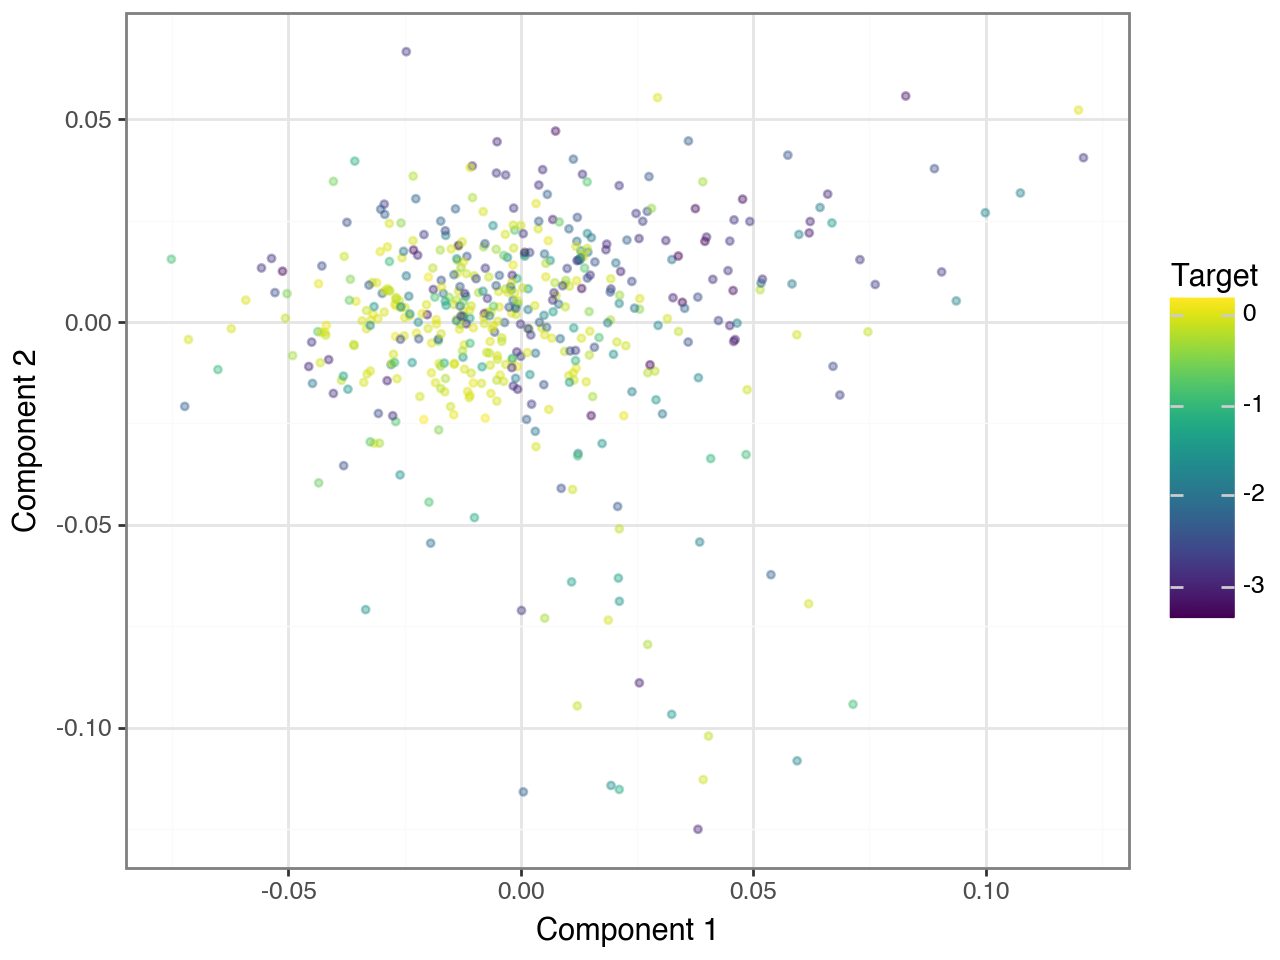

In [33]:
plot = (
    pln.ggplot(tsne_df, pln.aes(x='Component 1', y='Component 2', color='Target'))
    + pln.geom_point(size=1, alpha=.4)
    + pln.theme_bw()
    )
plot.show()